# setting up Google Drive Environment, you can also download you file to local

In [1]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [2]:
# setup drive location, the id should be in the share link:
# https://drive.google.com/file/d/192JMR7SIqoa14vrs7Z9BXO3iK89pimJL/view?usp=share_link

# file = drive.CreateFile({'id':'192JMR7SIqoa14vrs7Z9BXO3iK89pimJL'}) # replace the id with id of file you want to access
# file.GetContentFile('watch_reviews.tsv')  # tab-separated=tsv

# Load data

In [3]:
import numpy as np
import pandas as pd
import nltk
import gensim

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

# instruction for ntlk: natural language processing package
# here we will use it for tokenize and find stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\white\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\white\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv('E:\Downloads\watch_reviews.tsv', sep='\t', error_bad_lines=False) 
# error_bad_lines : boolean, default True. Lines with too many fields, for NLP, cannot skip lines with too many fields

C:\Users\white\AppData\Local\Temp\ipykernel_4536\3132948462.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('E:\Downloads\watch_reviews.tsv', sep='\t', error_bad_lines=False)
b'Skipping line 8704: expected 15 fields, saw 22\nSkipping line 16933: expected 15 fields, saw 22\nSkipping line 23726: expected 15 fields, saw 22\n'
b'Skipping line 85637: expected 15 fields, saw 22\n'
b'Skipping line 132136: expected 15 fields, saw 22\nSkipping line 158070: expected 15 fields, saw 22\nSkipping line 166007: expected 15 fields, saw 22\nSkipping line 171877: expected 15 fields, saw 22\nSkipping line 177756: expected 15 fields, saw 22\nSkipping line 181773: expected 15 fields, saw 22\nSkipping line 191085: expected 15 fields, saw 22\nSkipping line 196273: expected 15 fields, saw 22\nSkipping line 196331: expected 15 fields, saw 22\n'
b'Skipping line 197000: expected 15 fields, saw 22\n

# Data processing and cleaning

In [5]:
df.dropna(subset=['review_body'],inplace=True)
df.reset_index() # must do this

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,0,US,3653882,R3O9SGZBVQBV76,B00FALQ1ZC,937001370,"Invicta Women's 15150 ""Angel"" 18k Yellow Gold ...",Watches,5,0,0,N,Y,Five Stars,Absolutely love this watch! Get compliments al...,2015-08-31
1,1,US,14661224,RKH8BNC3L5DLF,B00D3RGO20,484010722,Kenneth Cole New York Women's KC4944 Automatic...,Watches,5,0,0,N,Y,I love thiswatch it keeps time wonderfully,I love this watch it keeps time wonderfully.,2015-08-31
2,2,US,27324930,R2HLE8WKZSU3NL,B00DKYC7TK,361166390,Ritche 22mm Black Stainless Steel Bracelet Wat...,Watches,2,1,1,N,Y,Two Stars,Scratches,2015-08-31
3,3,US,7211452,R31U3UH5AZ42LL,B000EQS1JW,958035625,Citizen Men's BM8180-03E Eco-Drive Stainless S...,Watches,5,0,0,N,Y,Five Stars,"It works well on me. However, I found cheaper ...",2015-08-31
4,4,US,12733322,R2SV659OUJ945Y,B00A6GFD7S,765328221,Orient ER27009B Men's Symphony Automatic Stain...,Watches,4,0,0,N,Y,"Beautiful face, but cheap sounding links",Beautiful watch face. The band looks nice all...,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960051,960199,US,39508379,REH8UQZAXQS40,B00005OT9I,2153632,Xhilaration&#174; Silver Dial Bangle Watch,Watches,2,17,17,N,N,Great prize - but size??,It's a great watch - but you don't have a chan...,2001-12-13
960052,960200,US,44704251,RJ14QPZEOI9P8,B00005QEM6,903687397,Armitron Men's Titanium 3 Eye Sport Analog Chr...,Watches,5,9,10,N,N,A very classy watch!,"Well worth the price. This is a light weight, ...",2001-11-08
960053,960201,US,40571775,R2B1G5650WWFCE,B00005QEME,252821780,Men's Timex Internet Messenger Sport Watch,Watches,5,3,16,N,N,This is a great watch,"Dear Targeteers,<BR>This watch is exelent. it ...",2001-11-06
960054,960202,US,44474855,R2MMGPUWXXOFI2,B00004YK0H,118389241,Energizer 393 Button Cell Battery,Watches,4,0,0,N,N,Now watt a minute here.,"In the old days, the common hearing battery in...",2001-04-05


setting up training and testing

In [6]:
data = df.loc[:999,'review_body'].tolist()

# tokenizing and stemming
Load stopwords and stemmer function from NLTK library. Stop words are words like "a", "the", or "in" which don't convey significant meaning. Stemming is the process of breaking a word down into its root.

In [7]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("br") #html <br>
stopwords.append("watch")

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords)

We use 183 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not

In [8]:
# Stemming
# Stemming is a normalization technique where list of tokenized words are converted into shorten root words to remove redundancy. Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form.
# A computer program that stems word may be called a stemmer.
# A stemmer reduce the words like fishing, fished, and fisher to the stem fish. The stem need not be a word, for example the Porter algorithm reduces, argue, argued, argues, arguing, and argus to the stem argu .
from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer 

stemmer = SnowballStemmer('english')

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


# Term Frequency and Inverse Document Frequency


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
# term frequency: 词语出现的次数，简单粗暴地认为，词语出现的次数越高就越重要，但是是错的
# 例：我们，的，是。。。不重要，不具有代表性，
# 同时，有一些词出现的频率少，但是很重要，比如：篮球，足球。。。
# TF: 某个文档中出现的频率/所有文档中出现的频率   在sklearn中TF=N 没有做归一化
# IDF: log(总的文档数/某个词语所在文档数)
# TF-IDF: TF*IDF  TF-IDF越大 就越重要          在sklearn中做了平滑  log(总的文档数+1/某个词语所在文档数+1)+1  保证分母不等于0
# 缺点：单纯认为频率小的重要，大的不重要，并且没有办法比较上下文关系

# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(data) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " reviews and " + str(tfidf_matrix.shape[1]) + " terms.")

C:\Users\white\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  warnings.warn(


In total, there are 999 reviews and 239 terms.


In [10]:
tfidf_matrix

<999x239 sparse matrix of type '<class 'numpy.float64'>'
	with 6887 stored elements in Compressed Sparse Row format>

In [11]:
tfidf_matrix.toarray()

array([[0.        , 0.51260836, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [12]:
# toarray returns an ndarray; todense returns a matrix
tfidf_matrix.todense()

matrix([[0.        , 0.51260836, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [13]:
tf_selected_words = tfidf_model.get_feature_names()  #get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
tf_selected_words

C:\Users\white\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abl',
 'absolut',
 'accur',
 'actual',
 'adjust',
 'alarm',
 'alreadi',
 'alway',
 'amaz',
 'amazon',
 'anoth',
 'arm',
 'arriv',
 'automat',
 'awesom',
 'bad',
 'band',
 'batteri',
 'beauti',
 'best',
 'better',
 'big',
 'bit',
 'black',
 'blue',
 'bought',
 'box',
 'bracelet',
 'brand',
 'break',
 'bright',
 'broke',
 'button',
 'buy',
 'ca',
 'came',
 'case',
 'casio',
 'chang',
 'cheap',
 'clasp',
 'classi',
 'clock',
 'color',
 'come',
 'comfort',
 'compliment',
 'cool',
 'cost',
 'crown',
 'crystal',
 'dark',
 'date',
 'daughter',
 'day',
 'deal',
 'definit',
 'deliveri',
 'design',
 'dial',
 'differ',
 'difficult',
 'disappoint',
 'display',
 'dress',
 'durabl',
 'easi',
 'easili',
 'end',
 'everi',
 'everyday',
 'everyth',
 'exact',
 'excel',
 'expect',
 'expens',
 'face',
 'fair',
 'far',
 'fast',
 'featur',
 'feel',
 'fell',
 'fine',
 'finish',
 'fit',
 'function',
 'gave',
 'gift',
 'gold',
 'good',
 'got',
 'great',
 'hand',
 'happi',
 'hard',
 'heavi',
 'high',
 'hold',


# k-means clustering


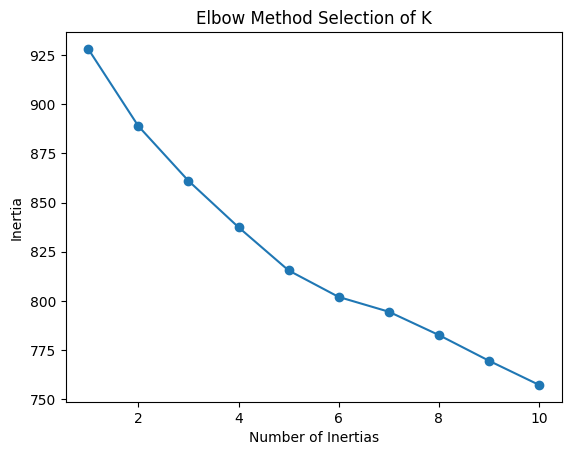

In [14]:
# k-means clustering
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
# select number of clusters
inertias = []
for i in range(1,11):
    k_mean=KMeans(n_clusters=i)
    k_mean.fit(tfidf_matrix)
    inertias.append(k_mean.inertia_)

plt.plot(range(1,11),inertias, marker='o')#bx-
plt.title('Elbow Method Selection of K')
plt.xlabel('Number of Inertias')
plt.ylabel('Inertia')
plt.show()



In [15]:
# k-means clustering
from sklearn.cluster import KMeans

num_clusters = 5

# number of clusters
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

## analyze the result

In [16]:
# create DataFrame films from all of the input files.
product = { 'review': df[:999].review_body, 'cluster': clusters}
frame = pd.DataFrame(product, columns = ['review', 'cluster'])
frame

,review,cluster
0,Absolutely love this watch! Get compliments al...,3
1,I love this watch it keeps time wonderfully.,3
2,Scratches,4
3,"It works well on me. However, I found cheaper ...",4
4,Beautiful watch face. The band looks nice all...,4
...,...,...
995,"Excellent replacement/alternate watch, consid...",4
996,"I'm late getting to the party, but after disco...",4
997,Wear it all the time!,4
998,very good.,2


In [17]:
print ("Number of reviews included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of reviews included in each cluster:


,cluster
4,671
3,110
1,84
2,72
0,62


In [18]:
km.cluster_centers_

# 239数的list -> cluster 0的中心点的tf-idf值
#-> assumption: 中心点的值可以代表这个cluster
#-> tf-idf值越大，对应的词越能代表这个document
#-> 选出了tf-idf最大的6个值对应的词来代表这个cluster

array([[0.        , 0.        , 0.        , ..., 0.        , 0.00784238,
        0.        ],
       [0.00383937, 0.        , 0.        , ..., 0.00265319, 0.        ,
        0.02313368],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0091084 ,
        0.        ],
       [0.        , 0.04163658, 0.        , ..., 0.01233311, 0.01732985,
        0.        ],
       [0.00562263, 0.0043456 , 0.00380552, ..., 0.00649093, 0.01789951,
        0.01438603]])

In [19]:
km.cluster_centers_.shape

(5, 239)

In [20]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews): ")
    print (", ".join(cluster_reviews))
    print ()

<Document clustering result by K-means>
Cluster 0 words:nice,price,look,realli,simpl,good,
Cluster 0 reviews (62 reviews): 
Nice watch, on time delivery from seller., It works well with nice simple look., vary nice, Very nice watch !!!, nice watch what you see on the picture is what you get, Very nice watch for running, Nice, Nice, Good Nice watch, Nice desing. I love this watch., Nice, Very nice and reasonably price!, Nice watch, a little complicated getting set up, but has nice features, probably more than I'll ever use. Great looking!, Very nice, the nice watch, Its really nice and it looks good to me. Thumbs up!, Very nice and simple!!!!, Nice watch. Not what I was expecting but that is not the sellers fault., Very nice watch! Very comfortable to wear., Nice watch, on time delivery from the seller., Very nice looking watch., Nice and strong, I love it. Really nice., Super nice, Very nice watch for the money!, nice, Nice quality, very good precision. Leather belt is really nice., Ni

In [21]:
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster_reviews = frame[frame.cluster==i].review.tolist()
    print ("Cluster " + str(i) + " reviews (" + str(len(cluster_reviews)) + " reviews) ")

    print ()

Cluster 0 words:nice,price,look,realli,simpl,good,
Cluster 0 reviews (62 reviews) 

Cluster 1 words:great,look,price,work,product,comfort,
Cluster 1 reviews (84 reviews) 

Cluster 2 words:good,product,price,qualiti,love,work,
Cluster 2 reviews (72 reviews) 

Cluster 3 words:love,wife,look,husband,absolut,beauti,
Cluster 3 reviews (110 reviews) 

Cluster 4 words:look,like,work,band,time,beauti,
Cluster 4 reviews (671 reviews) 



#### model evaluation for k-means clustering

In [25]:
from sklearn.metrics import silhouette_score
score = silhouette_score(tfidf_matrix, km.labels_, metric='euclidean')
score

0.07174131096891136

## topic modeling- Latent Dirichlet Allocation LDA

In [26]:
#将出现的词语的词频转化为词频向量，并对他们进行分类 分topic
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5)

In [27]:
lda_output = lda.fit_transform(tfidf_matrix)
print(lda_output.shape)
print(lda_output)

(999, 5)
[[0.0619206  0.75782943 0.06031638 0.0597995  0.06013409]
 [0.65732943 0.0881475  0.08399883 0.08629973 0.08422451]
 [0.2        0.2        0.2        0.2        0.2       ]
 ...
 [0.6604091  0.08531197 0.08641248 0.08334822 0.08451823]
 [0.10000018 0.10014279 0.10000125 0.10000038 0.5998554 ]
 [0.06689019 0.72769687 0.06673689 0.07165998 0.06701608]]


In [28]:
# topics and words matrix
topic_word = lda.components_
print(topic_word.shape)
print(topic_word)

(5, 239)
[[ 0.2021123   0.20044204  0.20556991 ...  0.6756322   0.20210099
   4.31993782]
 [ 4.28770776  7.69175255  1.38932695 ...  1.00830004 15.24660225
   3.95004705]
 [ 0.20018221  0.20041668  1.23232894 ...  2.27791369  0.20509086
   3.00863141]
 [ 0.20436953  0.20278955  0.2001256  ...  2.772147    0.200535
   0.20382812]
 [ 0.20092004  0.2005204   0.5261547  ...  0.200933    0.20455849
   1.11381132]]


In [29]:
# column names
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
doc_names = ["Doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

# get dominant topic for each document
topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = topic

df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,topic
Doc0,0.06,0.76,0.06,0.06,0.06,1
Doc1,0.66,0.09,0.08,0.09,0.08,0
Doc2,0.20,0.20,0.20,0.20,0.20,0
Doc3,0.76,0.06,0.06,0.06,0.06,0
Doc4,0.04,0.84,0.04,0.04,0.04,1
Doc5,0.08,0.70,0.08,0.08,0.07,1
Doc6,0.07,0.55,0.25,0.06,0.06,1
Doc7,0.06,0.06,0.06,0.75,0.06,3
Doc8,0.04,0.82,0.05,0.04,0.04,1
Doc9,0.67,0.06,0.06,0.16,0.06,0


In [31]:
df_document_topic['topic'].value_counts().to_frame()

,topic
1,392
0,244
2,153
4,131
3,79


In [32]:
# topic word matrix
print(lda.components_)
# topic-word matrix
df_topic_words = pd.DataFrame(lda.components_)

# column and index
df_topic_words.columns = tfidf_model.get_feature_names()
df_topic_words.index = topic_names

df_topic_words.head()

[[ 0.2021123   0.20044204  0.20556991 ...  0.6756322   0.20210099
   4.31993782]
 [ 4.28770776  7.69175255  1.38932695 ...  1.00830004 15.24660225
   3.95004705]
 [ 0.20018221  0.20041668  1.23232894 ...  2.27791369  0.20509086
   3.00863141]
 [ 0.20436953  0.20278955  0.2001256  ...  2.772147    0.200535
   0.20382812]
 [ 0.20092004  0.2005204   0.5261547  ...  0.200933    0.20455849
   1.11381132]]


C:\Users\white\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abl,absolut,accur,actual,adjust,alarm,alreadi,alway,amaz,amazon,...,weight,went,wife,wind,wish,work,worn,worth,wrist,year
Topic0,0.202112,0.200442,0.205570,0.204143,0.201166,1.963110,4.956376,0.885643,0.201534,0.908551,...,0.200867,1.853821,0.200829,0.991485,1.341702,23.487815,0.201015,0.675632,0.202101,4.319938
Topic1,4.287708,7.691753,1.389327,2.522060,4.644862,0.203041,0.202732,0.215989,9.964048,3.659513,...,3.599787,0.211541,9.373538,1.694870,2.382922,5.642476,2.665287,1.008300,15.246602,3.950047
Topic2,0.200182,0.200417,1.232329,0.334112,1.035538,0.201745,0.202061,0.201981,0.202046,0.203020,...,1.515402,0.451960,0.200468,0.200403,0.200147,3.812178,0.202171,2.277914,0.205091,3.008631
Topic3,0.204370,0.202790,0.200126,2.411473,0.207588,0.201273,0.200409,3.335677,0.200278,1.829077,...,0.200678,0.204363,1.156468,1.140594,0.200893,0.202204,0.200573,2.772147,0.200535,0.203828
Topic4,0.200920,0.200520,0.526155,0.383572,0.202236,3.370813,0.201602,0.200312,0.201106,0.201881,...,0.201500,0.995279,1.711058,0.206437,0.444773,7.912940,0.934158,0.200933,0.204558,1.113811


In [33]:
# print top n keywords for each topic
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # for each topic, we have words weight
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=15)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words

C:\Users\white\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,nice,work,excel,time,expect,price,love,realli,fast,thank,set,day,stop,deliveri,ship
Topic 1,love,look,beauti,band,perfect,color,wrist,great,pictur,like,wear,gift,watch,size,qualiti
Topic 2,great,product,look,broke,band,comfort,feel,bit,time,seller,valu,strap,wear,water,cheap
Topic 3,awesom,batteri,bought,love,simpl,came,recommend,quick,product,solid,husband,money,cool,look,high
Topic 4,good,like,work,littl,date,super,time,big,light,want,look,clock,bad,display,read
